In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from scipy.stats import loguniform
from skorch.callbacks import EpochScoring
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score
from scipy.stats import uniform, randint
from skorch import NeuralNetClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import torch.optim as optim

To do:

Instead of PIL image use torchvision.read_image

In [119]:
class BreastScanDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {i: label for i, label in enumerate(data.columns[3:])}  # Create a mapping from class index to label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.root_dir+self.data.iloc[idx, 2][1:]
        image = Image.open(img_path).convert('RGB')  # Convert image to 'RGB'
        label_vector = self.data.iloc[idx, 3:]
        label_index = torch.argmax(torch.tensor(label_vector))  # Convert one-hot vector to class index

        if self.transform:
            image = self.transform(image)
            
        return image, label_index

    def get_label(self, index):
        return self.label_map[index]

    def get_targets(self):
        targets = self.data.iloc[:, 3:].apply(lambda x: torch.argmax(torch.tensor(x)), axis=1)
        return targets.values


In [113]:
dataset_path ='/data/md311/Breast_Cancer_Detection_DBT/dataset/' 
df = pd.read_csv(dataset_path+'data_csv/train-v2_table_list_slice.csv')
# only work with a small portion of the dataset
df.drop(df.tail(16000).index, axis=0, inplace=True)
df

,StudyUID,view,img_path,Normal,Actionable,Benign,Cancer
0,DBT-S00163,rmlo,./images/train-v2/DBT-S00163_rmlo_16.png,0,0,1,0
1,DBT-S04378,lcc,./images/train-v2/DBT-S04378_lcc_31.png,0,1,0,0
2,DBT-S04378,lmlo,./images/train-v2/DBT-S04378_lmlo_33.png,0,1,0,0
3,DBT-S04378,rcc,./images/train-v2/DBT-S04378_rcc_29.png,0,1,0,0
4,DBT-S04378,rmlo,./images/train-v2/DBT-S04378_rmlo_31.png,0,1,0,0
...,...,...,...,...,...,...,...
892,DBT-S02614,rmlo,./images/train-v2/DBT-S02614_rmlo_29.png,0,1,0,0
893,DBT-S01815,lcc,./images/train-v2/DBT-S01815_lcc_29.png,1,0,0,0
894,DBT-S01815,lmlo,./images/train-v2/DBT-S01815_lmlo_31.png,1,0,0,0
895,DBT-S01815,rcc,./images/train-v2/DBT-S01815_rcc_26.png,1,0,0,0


In [114]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input size
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet mean and std
])

# Create a new column indicating whether each study includes at least one image where 'Cancer' is 1
df['StudyHasCancer'] = df.groupby('StudyUID')['Cancer'].transform('max')

# Get the unique studies and their cancer status
unique_studies = df[['StudyUID', 'StudyHasCancer']].drop_duplicates()

# Split the studies using stratified sampling based on the 'StudyHasCancer' column
train_studies, test_studies = train_test_split(unique_studies, test_size=0.2, stratify=unique_studies['StudyHasCancer'], random_state=42)

# Get the training and test data
train_data = df[df['StudyUID'].isin(train_studies['StudyUID'])]
test_data = df[df['StudyUID'].isin(test_studies['StudyUID'])]

# Create datasets
train_dataset = BreastScanDataset(train_data, dataset_path, transform)
test_dataset = BreastScanDataset(test_data, dataset_path, transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [136]:
# Define the function to load the pre-trained model and modify the final layer
def load_resnet50_model(num_classes, freeze_params=False, saved_weights_path=None):
    # Load the pretrained model
    model = models.resnet50(weights='DEFAULT')
    
    if freeze_params==True:
        # Freeze model parameters
        for param in model.parameters():
            param.requires_grad = False
    
    # Get the input of the fc layer
    num_ftrs = model.fc.in_features
    
    # Re-define the fc layer / classifier
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Load the model weights from the saved file
    if saved_weights_path is not None:
        model.load_state_dict(torch.load(saved_weights_path))
    
    return model

# Define the function to get the loss function and the optimizer
def get_loss_optimizer(model, learning_rate):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)
    
    return criterion, optimizer

def train_model_cv(model, criterion, optimizer, dataset, train_loader, device, num_epochs, n_splits, save_path=None):
    model.to(device)
    
    # Initialize the KFold class
    kfold = KFold(n_splits=n_splits, shuffle=True)

    # Initialize lists to store the loss values
    train_losses = []
    val_losses = []
    epochs = []

    start_time = time.time()

    # Start the k-fold cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Define the data loaders for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=val_subsampler)

        # Train the model
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            print(f'Train Loss: {epoch_loss:.4f}')
            train_losses.append(epoch_loss)
            epochs.append(epoch)

            # Validation
            model.eval()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Validation"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs.size(0)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(val_loader.dataset)
            print(f'Validation Loss: {epoch_loss:.4f}')
            val_losses.append(epoch_loss)
    
    end_time = time.time()
    print(f"Model training complete.\nITotal training time: {end_time - start_time:.6f} seconds")

    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print("Weights saved to",save_path)
        
    # plot loss
    plot_loss(epochs, train_losses, val_losses)


# Define the function to evaluate the model
def evaluate_model(model, test_loader, device, num_classes):
    # Evaluate the model
    print("Evaluating Model...")
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Get the predicted probabilities for all classes
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())  # Append the probabilities as a 2D array

    all_probs = np.vstack(all_probs)  # Stack the probabilities

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    roc_auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')

    print(f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}\nAUC: {roc_auc:.2f}")

    # Plot confusion matrix
    unique_labels = [train_dataset.get_label(i) for i in np.sort(np.unique(all_labels))]
    plot_confusion_matrix(all_labels,all_preds,"Hey", unique_labels)

    # Plot ROC curve
    plot_roc_curve(np.eye(num_classes)[all_labels], all_probs, num_classes, unique_labels)

def plot_confusion_matrix(y_true, y_pred, task, unique_labels):
    
    plt.figure(figsize=(9,7),dpi=150)
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_pred), index=unique_labels, columns=unique_labels)
    print('\nConfusion Matrix:\n')
    print(conf_mat)
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', linewidth=.5, square=True)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title("Confusion Matrix")
    plt.show()
    # plt.savefig('fig/confusion_matrix_'+task+'.png')

def plot_loss(epochs, train_losses, val_losses):
    
    plt.figure(figsize=(9,7),dpi=150)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Error Loss per Epoch")

    # Create a DataFrame from the lists
    loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': train_losses,
        'Validation Loss': val_losses
    })

    # Plot the training and validation loss
    sns.lineplot(data=loss_df, x='Epoch', y='Training Loss')
    sns.lineplot(data=loss_df, x='Epoch', y='Validation Loss')
    plt.show()
    # plt.savefig('fig/Training_Loss.png')

def plot_roc_curve(y_true, y_score, num_classes, class_labels):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve
    plt.figure(figsize=(9,7),dpi=150)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## Hyper-parameter Tuning

In [137]:
def hyperparameter_tuning(dataset, device, num_epochs, n_splits, num_trials):
    # Define the hyperparameters to tune
    learning_rates = [10**(-random.uniform(3, 5)) for _ in range(num_trials)]
    momentums = [random.uniform(0, 1) for _ in range(num_trials)]
    weight_decays = [10**(-random.uniform(3, 5)) for _ in range(num_trials)]
    batch_sizes = [2**i for i in range(4, 9)]
    dropout_rates = [random.uniform(0, 0.5) for _ in range(num_trials)]

    best_auc = 0
    best_params = {}

    start_time = time.time()

    # Perform random search
    for trial in range(num_trials):
        print(f'Trial {trial+1}/{num_trials}')
        print('--------------------------------')

        # Randomly select hyperparameters
        lr = random.choice(learning_rates)
        momentum = random.choice(momentums)
        weight_decay = random.choice(weight_decays)
        batch_size = random.choice(batch_sizes)
        dropout_rate = random.choice(dropout_rates)

        # Load the model
        model = load_resnet50_model(num_classes=4, freeze_params=True)
        model.to(device)

        # Define the loss function and the optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

        # Initialize the KFold class
        kfold = KFold(n_splits=n_splits, shuffle=True)

        # Start the k-fold cross-validation
        for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
            print(f'FOLD {fold}')
            # Define the data loaders for training and validation
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
            train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
            val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

            # Train the model
            model.train()
            for epoch in range(num_epochs):
                for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Validation
            model.eval()
            all_preds = []
            all_labels = []
            all_probs = []
            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc="Validation"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    probs = torch.nn.functional.softmax(outputs, dim=1)  # Get the predicted probabilities for all classes
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.append(probs.cpu().numpy())
            
            all_probs = np.vstack(all_probs)  # Stack the probabilities

            # Calculate AUC
            auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')

            # Update best AUC and best parameters
            if auc > best_auc:
                best_auc = auc
                best_params = {'learning_rate': lr, 'momentum': momentum, 'weight_decay': weight_decay, 'batch_size': batch_size, 'dropout_rate': dropout_rate}

    end_time = time.time()

    print(f"Hyperparameter tuning complete.\nTime taken: {end_time - start_time:.2f} seconds")
    print(f"Best AUC: {best_auc:.2f}")
    print(f"Best parameters: {best_params}")

    return best_params

In [116]:
num_classes = 4 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
num_epochs = 1
n_splits = 2
n_iter = 3
num_trials = 1
hyperparameter_tuning(train_dataset, device, num_epochs, n_splits, num_trials)

Trial 1/1
--------------------------------


Validation: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:36<00:00, 18.43s/it]

Hyperparameter tuning complete.
Time taken: 146.01 seconds
Best AUC: 0.52
Best parameters: {'learning_rate': 0.0008386346509827971, 'momentum': 0.031755431854909144, 'weight_decay': 0.00017708102868675967, 'batch_size': 256, 'dropout_rate': 0.06711838488312538}


{'learning_rate': 0.0008386346509827971,
 'momentum': 0.031755431854909144,
 'weight_decay': 0.00017708102868675967,
 'batch_size': 256,
 'dropout_rate': 0.06711838488312538}

FOLD 0
--------------------------------


Epoch 1/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.7212


Epoch 1/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3395


Epoch 2/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.6588


Epoch 2/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3242


Epoch 3/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.36s/it]


Train Loss: 0.6363


Epoch 3/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3272


Epoch 4/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.6208


Epoch 4/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.06s/it]


Validation Loss: 0.3235


Epoch 5/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.6081


Epoch 5/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.06s/it]


Validation Loss: 0.3234
FOLD 1
--------------------------------


Epoch 1/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.6907


Epoch 1/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3228


Epoch 2/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.6305


Epoch 2/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3173


Epoch 3/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.36s/it]


Train Loss: 0.6095


Epoch 3/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3087


Epoch 4/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.36s/it]


Train Loss: 0.5950


Epoch 4/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3123


Epoch 5/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.5784


Epoch 5/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3164
FOLD 2
--------------------------------


Epoch 1/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.6365


Epoch 1/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.06s/it]


Validation Loss: 0.3024


Epoch 2/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.36s/it]


Train Loss: 0.6162


Epoch 2/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3031


Epoch 3/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.36s/it]


Train Loss: 0.5966


Epoch 3/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.06s/it]


Validation Loss: 0.3015


Epoch 4/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.36s/it]


Train Loss: 0.5758


Epoch 4/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.04s/it]


Validation Loss: 0.3051


Epoch 5/5, Training: 100%|███████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Train Loss: 0.5560


Epoch 5/5, Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Validation Loss: 0.3050
Model training complete.
ITotal training time: 1123.820194 seconds
Weights saved to /data/md311/Breast_Cancer_Detection_DBT/models/dbt_classification_resnet.pth


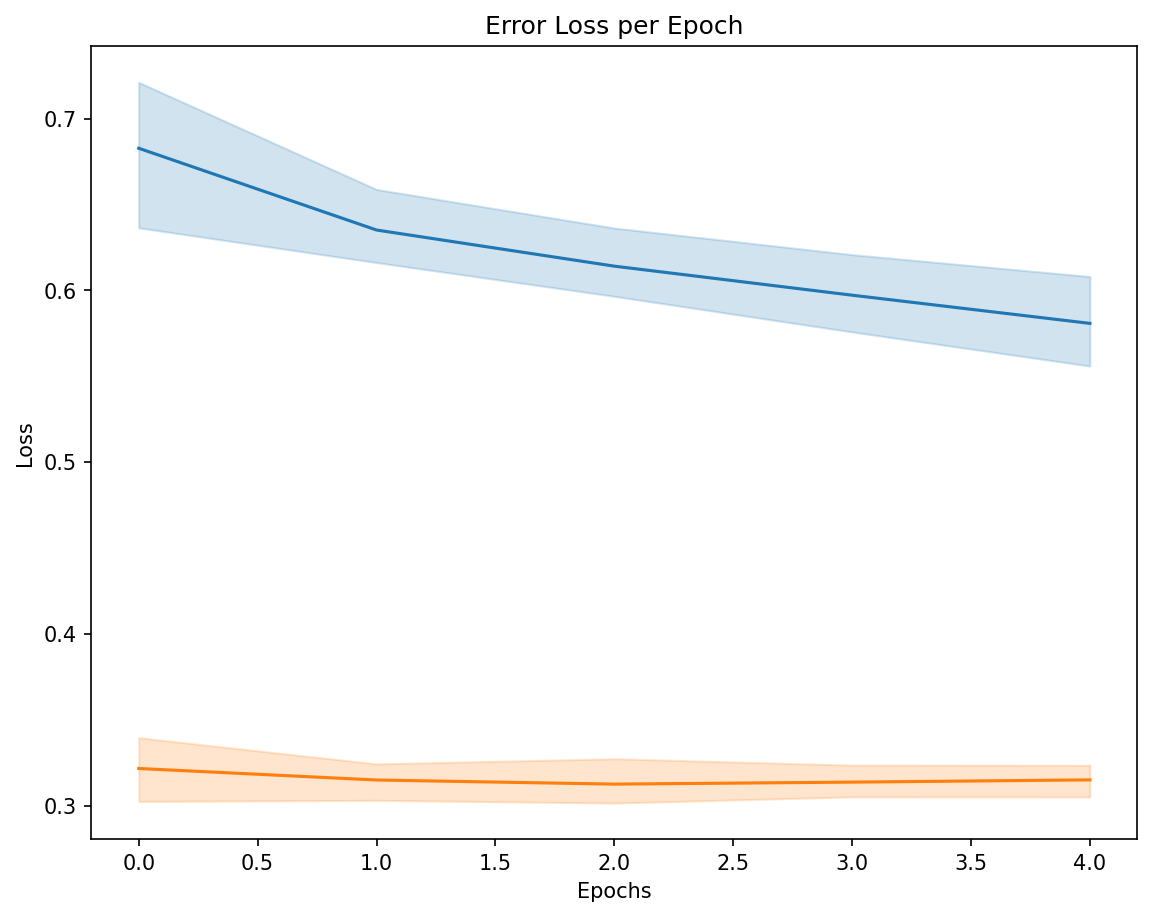

In [121]:
learning_rate = 0.001 
num_epochs = 5
n_splits = 3
model = load_resnet50_model(num_classes)
criterion, optimizer = get_loss_optimizer(model, learning_rate)
save_path = '/data/md311/Breast_Cancer_Detection_DBT/models/dbt_classification_resnet.pth'
train_model_cv(model, criterion, optimizer, train_dataset, train_loader, device, num_epochs, n_splits, save_path) 

Evaluating Model...


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.68
Precision: 0.21
Recall: 0.24
F1: 0.21
AUC: 0.44

Confusion Matrix:

            Normal  Actionable  Benign  Cancer
Normal         129           7       0       0
Actionable      35           1       0       0
Benign           4           0       0       0
Cancer          16           0       0       0


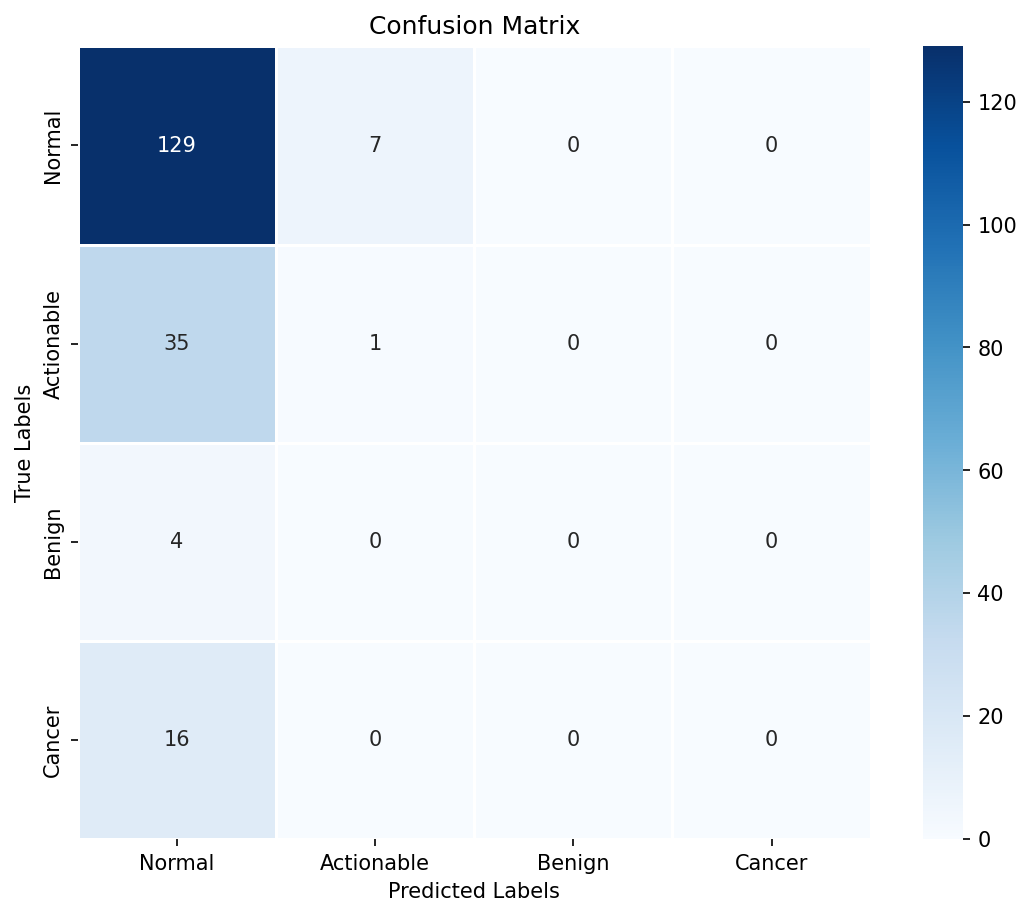

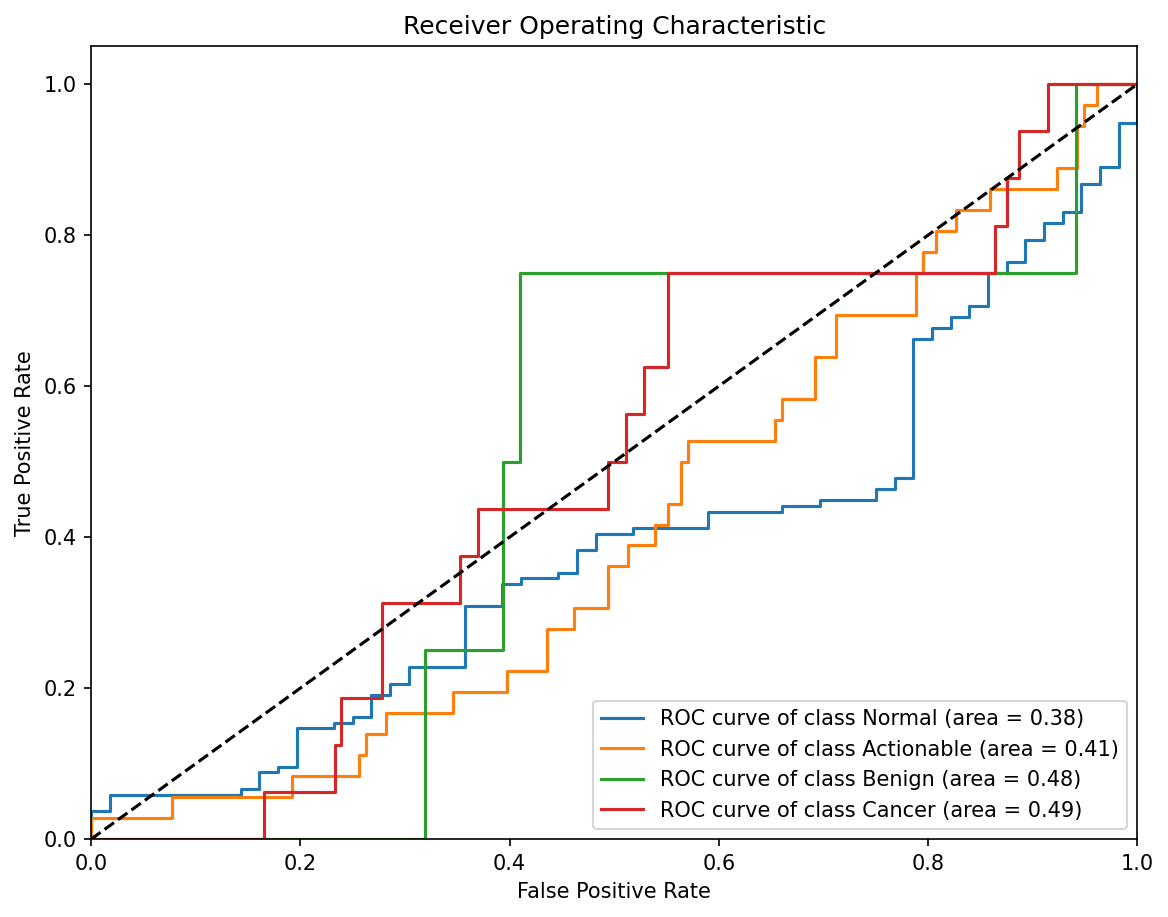

In [122]:
evaluate_model(model, test_loader, device, num_classes)  # Replace test_loader with your actual test data loader

In [58]:
def predict_image(model, image_path, device, transform, class_labels):
    # Load and display the image
    image = Image.open(image_path)

    plt.figure(figsize=(5,5),dpi=150)
    plt.axis('off')
    plt.imshow(np.array(image), cmap='gray')
    plt.show()

    image = image.convert('RGB')

    # Apply the transformations to the image
    image = transform(image)

    # Add an extra batch dimension since pytorch treats all images as batches
    image = image.unsqueeze(0)

    # Move the input and model to GPU for speed if available
    image = image.to(device)
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference on the image
    start_time = time.time()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        prob = torch.nn.functional.softmax(output, dim=1)[0] * 100
    end_time = time.time()

    # Print the class label and the corresponding probability
    print(f'The model predicts this image as a {class_labels[predicted]}, with a confidence of {prob[predicted].item():.2f}%.')

    print(f"Inference time: {end_time - start_time:.6f} seconds")

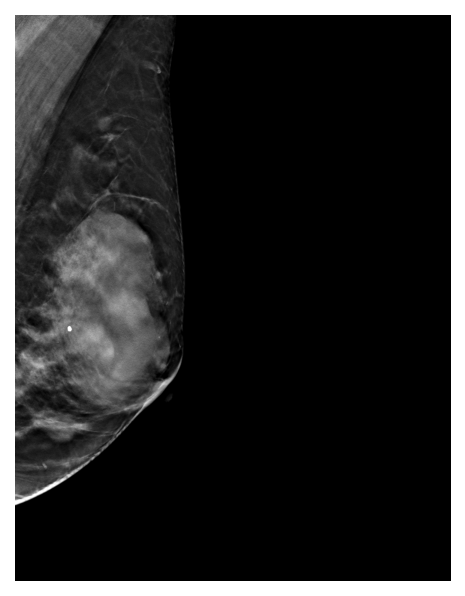

The model predicts this image as a Normal, with a confidence of 78.23%.
Inference time: 0.006163 seconds


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise use CPU
class_labels = ['Normal', 'Actionable', 'Benign', 'Cancer']
model = load_resnet50_model(num_classes=4, saved_weights_path='/data/md311/Breast_Cancer_Detection_DBT/models/dbt_classification_resnet.pth')
img_path = '/data/md311/Breast_Cancer_Detection_DBT/dataset/images/train-v2/DBT-S00144_rmlo_29.png'
predict_image(model, img_path, device, transform, class_labels)
